In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rosbag
import pymap3d as pm

from scipy.signal import savgol_filter
%matplotlib inline

def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

def to_euler(x, y, z, w):
    """Return as xyz (roll pitch yaw) Euler angles."""
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = np.arcsin(2 * (w * y - z * x))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return np.array([roll, pitch, yaw])

In [3]:
ls

 waypoints_interpolated.npy         waypoints_u_turn_kiri_1.npy
 waypoints.ipynb                   'waypoint_u turn_kanan_1.bag'
 waypoints_lab.ipynb               'waypoint_u turn_kanan_2.bag'
 waypoints.npy                     'waypoint_u turn_kanan_3.bag'
 waypoints.png                     'waypoint_u turn_kiri_1.bag'
 waypoints_u_lab_kanan_interp.npy  'waypoint_u turn_kiri_2.bag'
 waypoints_u_lab_kanan.npy          waypoint_u_turn_lab_kanan.bag
 waypoints_u_turn_kanan_2.npy       waypoint_u_turn_lab_kiri.bag


In [4]:
bag = rosbag.Bag('waypoint_u_turn_lab_kanan.bag')
bag.get_type_and_topic_info()

TypesAndTopicsTuple(msg_types={'diagnostic_msgs/DiagnosticArray': '60810da900de1dd6ddd437c3503511da', 'dynamic_reconfigure/Config': '958f16a05573709014982821e6822580', 'dynamic_reconfigure/ConfigDescription': '757ce9d44ba8ddd801bb30bc456f946f', 'geometry_msgs/Twist': '9f195f881246fdfa2798d1d3eebca84a', 'geometry_msgs/TwistStamped': '98d34b0043a2093cf9d9345ab6eef12e', 'rosgraph_msgs/Log': 'acffd30cd6b6de30f120938c17c593fb', 'sensor_msgs/Imu': '6a62c6daae103f4ff57a132d6f95cec2', 'sensor_msgs/NavSatFix': '2d3a8cd499b9b4a0249fb98fd05cfa48', 'sensor_msgs/TimeReference': 'fded64a0265108ba86c3d38fb11c0c16'}, topics={'/diagnostics': TopicTuple(msg_type='diagnostic_msgs/DiagnosticArray', message_count=73, connections=2, frequency=1.0010710492929702), '/fix': TopicTuple(msg_type='sensor_msgs/NavSatFix', message_count=363, connections=1, frequency=4.996654247414145), '/imu': TopicTuple(msg_type='sensor_msgs/Imu', message_count=3636, connections=1, frequency=50.058528667589634), '/imu_node/paramet

# CHECK 

In [5]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

In [6]:
# Ambil sb. x & sb. y saja dan ga ampe abis
#limm = 300 # u_turn_kanan_2
limm=-1 # u_turn_kiri_1
X_fm = (-1) * np.copy(gps_pos[:limm,:2])
ttime = np.copy(gps_t[:limm])

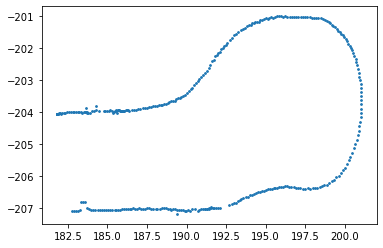

In [7]:
lim = [0, -1]
plt.scatter(X_fm[lim[0]:lim[1],0], X_fm[lim[0]:lim[1],1], s=3.)

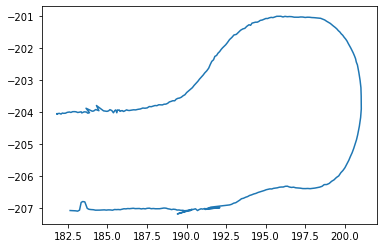

In [8]:
plt.plot(X_fm[:,0], X_fm[:,1])

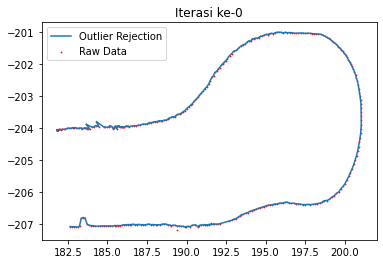

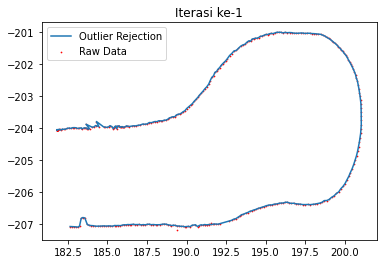

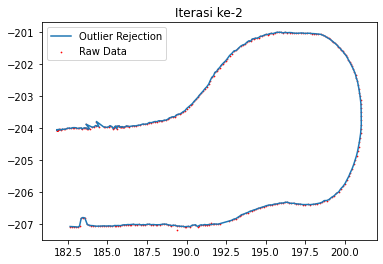

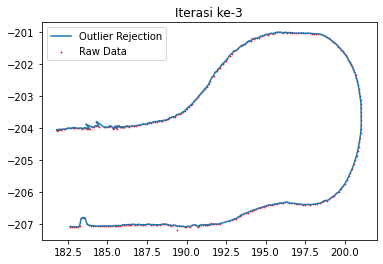

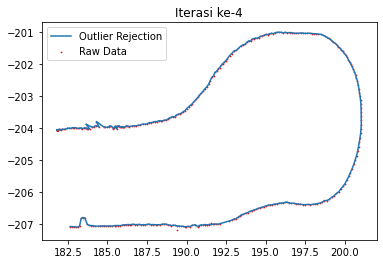

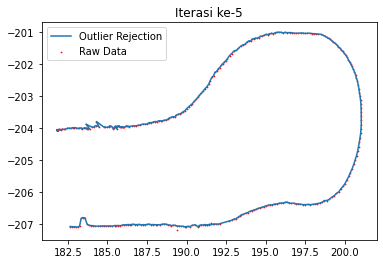

In [9]:
# Filter the waypoints and remove the outlier !
X_in = np.copy(X_fm)
t_in = np.copy(ttime)

for m in range(6):
    X_in_filtered = np.empty(X_in.shape)
    dt = np.empty(X_in.shape[0])
    dt[:-1] = t_in[1:] - t_in[:-1]
    dt[-1] = dt[-2]
    for i in range(2):
        X_in_filtered[:,i] = savgol_filter(X_in[:,i], 51, 3)
    dist = np.sqrt(np.sum((X_in_filtered[:, :2] - X_in[:, :2])**2, axis=-1))
    X_in = X_in[dist <= 0.5, :]
    t_in = t_in[dist <= 0.5]
    if m % 1 == 0:
        plt.scatter(X_fm[:,0], X_fm[:,1], label='Raw Data', s=0.5,color='red')
        plt.plot(X_in[:,0], X_in[:,1], label='Outlier Rejection')
        plt.legend()
        plt.title('Iterasi ke-{}'.format(m))
        plt.show()

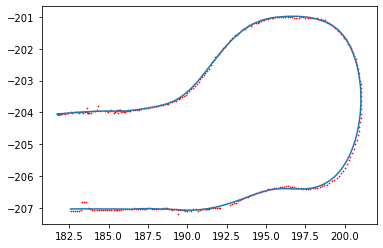

In [10]:
X_in_filtered = np.empty(X_in.shape)
for i in range(2):
    X_in_filtered[:,i] = savgol_filter(X_in[:,i], 51, 3)
plt.plot(X_in_filtered[:,0], X_in_filtered[:,1])
plt.scatter(X_fm[:,0], X_fm[:,1], color='red',s=0.5)

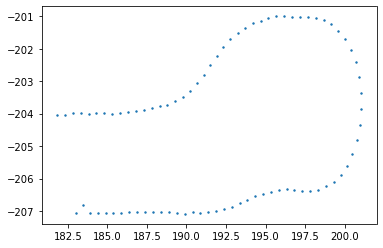

In [11]:
dst = 0.5
wp = [X_in[0]]
for i in range(1, X_in.shape[0]):
    while True:
        dist = np.linalg.norm(X_in[i] - wp[-1])
        if dist >= dst:
            wp.append(wp[-1] + dst*(X_in[i] - wp[-1])/dist)
        else:
            break
wp = np.array(wp)
plt.scatter(wp[:,0], wp[:,1], s=2.)

YES
YES


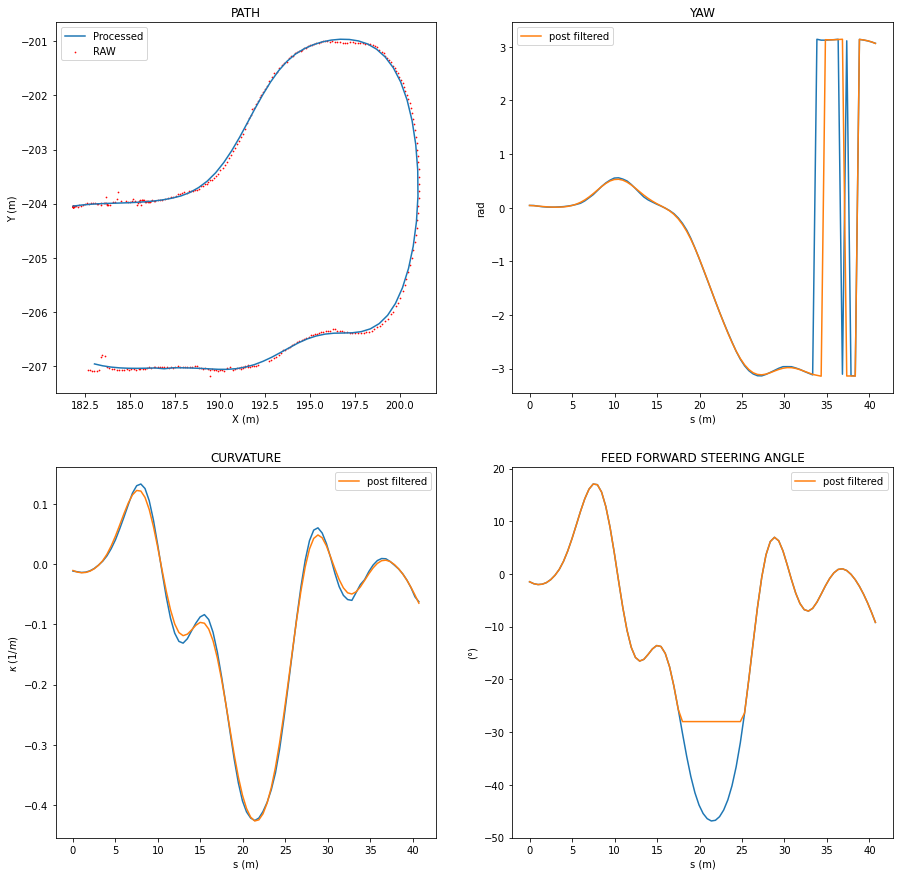

In [12]:
num_f = 15

dst = 0.5
wp = [X_in[0]]
for i in range(1, X_in.shape[0]):
    while True:
        dist = np.linalg.norm(X_in[i] - wp[-1])
        if dist >= dst:
            wp.append(wp[-1] + dst*(X_in[i] - wp[-1])/dist)
        else:
            break
    if dist >= dst:
        wp.append(wp[-1] + dst*(X_in[i] - wp[-1])/dist)
wp = np.array(wp)
print("YES")
for i in range(2):
    wp[:,i] = savgol_filter(wp[:,i], num_f, 3)
print("YES")
yaw = np.empty(wp.shape[0])
yaw[1:] = np.arctan2(wp[1:, 1] - wp[:-1, 1], wp[1:, 0] - wp[:-1, 0])
yaw[0] = yaw[1];
yawf = wrap_angle(savgol_filter(np.unwrap(yaw), num_f, 3))

s = np.zeros(wp.shape[0])
for i in range(1, s.shape[0]):
    s[i] = s[i-1] + np.linalg.norm(wp[i] - wp[i-1])

curvature = np.gradient(np.unwrap(yawf), s)
curvaturef = savgol_filter(curvature, num_f, 3)
steer = np.arctan(2.5 * curvaturef)*180/np.pi
steerf = savgol_filter(steer, num_f, 3)
steerf = np.copy(steer)
# Limiting the steering angle
steerf[steerf > 35.] = 35
steerf[steerf < -28.] = -28.

width = 15
height = 15
plt.figure(figsize=(width, height))

plt.subplot(2,2,1)
plt.plot(wp[:,0], wp[:,1], label='Processed')
plt.scatter(X_fm[:,0], X_fm[:,1], color='red',s=0.5, label='RAW')
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.legend()
plt.title("PATH")

plt.subplot(2,2,2)
plt.plot(s, yaw)
plt.plot(s, yawf, label='post filtered')
plt.title("YAW")
plt.xlabel('s (m)')
plt.ylabel('rad')
plt.legend()

plt.subplot(2,2,3)
plt.plot(s, curvature)
plt.plot(s, curvaturef, label='post filtered')
plt.legend()
plt.title("CURVATURE")
plt.xlabel('s (m)')
plt.ylabel(r'$\kappa\;(1/m)$')

plt.subplot(2,2,4)
plt.plot(s, steer)
plt.plot(s, steerf, label='post filtered')
plt.legend()
plt.title("FEED FORWARD STEERING ANGLE")
plt.xlabel('s (m)')
plt.ylabel(r'$(\degree)$')

plt.savefig('waypoints.png', dpi=600, transparent=True)
plt.show()

# INTERPOLATING THE WAYPOINTS

In [13]:
# Generate the velocity
v0 = 0.3 #m/s ~ 1.8 km/jam
vmax = 1.5 #m/s ~ 5.4 km/jam
accel = 0.2 #m/s2
num = wp.shape[0]
vel = [v0]
for i in range(1, num):
    vel.append(min(np.sqrt(vel[-1]**2 + 2*accel*dst), vmax))
vel = np.array(vel)
for i in range(num):
    if s[i] >= 36:
        vel[i] = 0.0
    elif s[i] >= 25:
        vel[i] = max(np.sqrt(max(vel[i-1]**2 - 2*accel*dst, 0.0)), v0)

In [14]:
waypoints_np = np.empty((wp.shape[0], 5))
waypoints_np[:,0] = wp[:,0]
waypoints_np[:,1] = wp[:,1]
waypoints_np[:,2] = yawf
waypoints_np[:,3] = vel
waypoints_np[:,4] = curvaturef

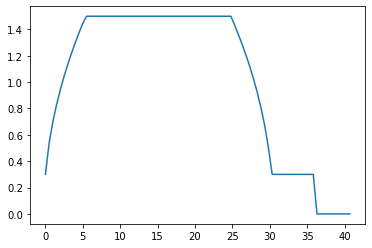

In [15]:
plt.plot(s, waypoints_np[:,3])

In [16]:
INTERP_DISTANCE_RES = 0.05 # distance between interpolated points

# Linear interpolation computations
# Compute a list of distances between waypoints
wp_distance = []   # distance array
for i in range(1, waypoints_np.shape[0]):
    wp_distance.append(
            np.sqrt((waypoints_np[i, 0] - waypoints_np[i-1, 0])**2 +
                    (waypoints_np[i, 1] - waypoints_np[i-1, 1])**2))
wp_distance.append(0)  # last distance is 0 because it is the distance
                       # from the last waypoint to the last waypoint

# Linearly interpolate between waypoints and store in a list
wp_interp      = []    # interpolated values 
                       # (rows = waypoints, columns = [x, y, v])
wp_interp_hash = []    # hash table which indexes waypoints_np
                       # to the index of the waypoint in wp_interp
interp_counter = 0     # counter for current interpolated point index
for i in range(waypoints_np.shape[0] - 1):
    # Add original waypoint to interpolated waypoints list (and append
    # it to the hash table)
    wp_interp.append(list(waypoints_np[i]))
    wp_interp_hash.append(interp_counter)   
    interp_counter+=1

    # Interpolate to the next waypoint. First compute the number of
    # points to interpolate based on the desired resolution and
    # incrementally add interpolated points until the next waypoint
    # is about to be reached.
    num_pts_to_interp = int(np.floor(wp_distance[i] /\
                                 float(INTERP_DISTANCE_RES)) - 1)
    wp_vector = waypoints_np[i+1] - waypoints_np[i]
    wp_uvector = wp_vector / np.linalg.norm(wp_vector)
    for j in range(num_pts_to_interp):
        next_wp_vector = INTERP_DISTANCE_RES * float(j+1) * wp_uvector
        wp_interp.append(list(waypoints_np[i] + next_wp_vector))
        interp_counter+=1
# add last waypoint at the end
wp_interp.append(list(waypoints_np[-1]))
wp_interp_hash.append(interp_counter)   
wp_interp = np.array(wp_interp)
wp_interp_hash = np.array(wp_interp_hash)
interp_counter+=1

In [17]:
#np.save('waypoints_u_turn_kanan_2', waypoints_np)
np.save('waypoints_u_lab_kanan', waypoints_np)
np.save('waypoints_u_lab_kanan_interp', wp_interp)

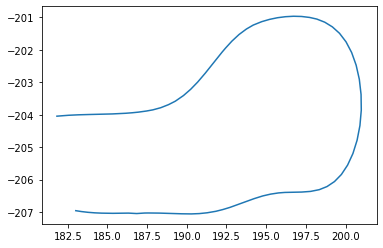

In [18]:
plt.plot(wp_interp[:,0], wp_interp[:,1])

# CHECK

In [19]:
wp_interp.shape

(766, 5)

In [21]:
waypoints_np[50]

array([ 198.83510218, -206.2165073 ,   -2.81338916,    1.5       ,
         -0.24990146])

In [22]:
wp_interp[60]

array([ 1.85105057e+02, -2.03978810e+02,  1.06067485e-02,  1.18608474e+00,
        2.86608339e-03])

In [23]:
bag = rosbag.Bag('waypoint_u_turn_lab_kiri.bag')
bag.get_type_and_topic_info()

TypesAndTopicsTuple(msg_types={'diagnostic_msgs/DiagnosticArray': '60810da900de1dd6ddd437c3503511da', 'dynamic_reconfigure/Config': '958f16a05573709014982821e6822580', 'dynamic_reconfigure/ConfigDescription': '757ce9d44ba8ddd801bb30bc456f946f', 'geometry_msgs/Twist': '9f195f881246fdfa2798d1d3eebca84a', 'geometry_msgs/TwistStamped': '98d34b0043a2093cf9d9345ab6eef12e', 'rosgraph_msgs/Log': 'acffd30cd6b6de30f120938c17c593fb', 'sensor_msgs/Imu': '6a62c6daae103f4ff57a132d6f95cec2', 'sensor_msgs/NavSatFix': '2d3a8cd499b9b4a0249fb98fd05cfa48', 'sensor_msgs/TimeReference': 'fded64a0265108ba86c3d38fb11c0c16'}, topics={'/diagnostics': TopicTuple(msg_type='diagnostic_msgs/DiagnosticArray', message_count=75, connections=2, frequency=1.0011821638742893), '/fix': TopicTuple(msg_type='sensor_msgs/NavSatFix', message_count=364, connections=1, frequency=5.001256781732546), '/imu': TopicTuple(msg_type='sensor_msgs/Imu', message_count=3647, connections=1, frequency=50.06958379839918), '/imu_node/paramete

# CHECK 

In [24]:
lat0, lon0, h0 = -6.8712, 107.5738, 768
gps_t = []
gps_pos = []
gps_cov = []
for topic, msg, _ in bag.read_messages(topics=['/fix']):
    gps_t.append(msg.header.stamp.to_sec())
    gps_pos.append(pm.geodetic2enu(msg.latitude, msg.longitude, msg.altitude, lat0, lon0, h0))
    gps_cov.append(msg.position_covariance)
gps_t = np.array(gps_t)
gps_pos = np.array(gps_pos)
gps_cov = np.array(gps_cov).reshape(-1,3,3)

In [25]:
# Ambil sb. x & sb. y saja dan ga ampe abis
#limm = 300 # u_turn_kanan_2
limm=-1 # u_turn_kiri_1
X_fm = (-1) * np.copy(gps_pos[:limm,:2])
ttime = np.copy(gps_t[:limm])

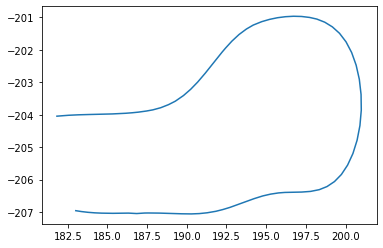

In [28]:
#plt.plot(X_fm[:,0], X_fm[:,1])
plt.plot(wp_interp[:,0], wp_interp[:,1])